In [53]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import lightning as L
from classification_module import LightningModel


In [54]:
train_idx = np.load("..\\Utilidades\\indices\\train_idx.npy")
val_idx   = np.load("..\\Utilidades\\indices\\val_idx.npy")
test_idx  = np.load("..\\Utilidades\\indices\\test_idx.npy")

In [55]:
#Leer archivos
datosResponseTime = pd.read_excel('../Datos/DatosConY0101 - Balanceado.xlsx', sheet_name='ICMP response time').to_numpy()
datosPaquetesEnviados = pd.read_excel('../Datos/DatosConY0101 - Balanceado.xlsx', sheet_name='Paquetes unicast enviados ETH').to_numpy()
datosPaquetesRecibidos = pd.read_excel('../Datos/DatosConY0101 - Balanceado.xlsx', sheet_name='Paquetes unicast recibidos ETH').to_numpy()
datosTraficoRecibido = pd.read_excel('../Datos/DatosConY0101 - Balanceado.xlsx', sheet_name='Trafico LAN Recibido').to_numpy()
datosTraficoTransmitido = pd.read_excel('../Datos/DatosConY0101 - Balanceado.xlsx', sheet_name='Trafico LAN Transmitido').to_numpy()


In [56]:
x_datosResponseTime = datosResponseTime[:,3:-1].astype(np.float32)
x_datosPaquetesEnviados = datosPaquetesEnviados[:,3:-1].astype(np.float32)
x_datosPaquetesRecibidos = datosPaquetesRecibidos[:,3:-1].astype(np.float32)
x_datosTraficoRecibido = datosTraficoRecibido[:,3:-1].astype(np.float32)
x_datosTraficoTransmitido = datosTraficoTransmitido[:,3:-1].astype(np.float32)
y = datosTraficoTransmitido[:,-1].astype(np.float32)

In [57]:
print("ResponseTime:", x_datosResponseTime.dtype)
print("PaquetesEnviados:", x_datosPaquetesEnviados.dtype)
print("PaquetesRecibidos:", x_datosPaquetesRecibidos.dtype)
print("TraficoRecibido:", x_datosTraficoRecibido.dtype)
print("TraficoTransmitido:", x_datosTraficoTransmitido.dtype)

ResponseTime: float32
PaquetesEnviados: float32
PaquetesRecibidos: float32
TraficoRecibido: float32
TraficoTransmitido: float32


In [58]:
X = np.array([x_datosResponseTime, x_datosPaquetesEnviados, x_datosPaquetesRecibidos,
              x_datosTraficoRecibido, x_datosTraficoTransmitido]).transpose(1,0,2)

In [59]:
X.shape
print(X.dtype)
print(type(X[0,0]))


float32
<class 'numpy.ndarray'>


In [60]:
X.shape, y.shape

((808, 5, 60), (808,))

In [61]:
X[1,0:,:].__len__()

5

In [62]:
X_T = torch.tensor(X, dtype=torch.float32)
y_T = torch.tensor(y, dtype=torch.long)

X_T = torch.nan_to_num(X_T, nan=0.0, posinf=1e6, neginf=-1e6)


In [63]:
# Normalización
mu = X_T[train_idx].mean(dim=(0,2), keepdim=True)
sigma = X_T[train_idx].std(dim=(0,2), keepdim=True).clamp_min(1e-6)
X_T = (X_T - mu) / sigma


dataset = torch.utils.data.TensorDataset(X_T, y_T)
from torch.utils.data import Subset
train_dataset = Subset(dataset, train_idx)
val_dataset   = Subset(dataset, val_idx)
test_dataset  = Subset(dataset, test_idx)

from collections import Counter
print("train dist:", Counter(y_T[train_idx].tolist()))
print("val   dist:", Counter(y_T[val_idx].tolist()))
print("test  dist:", Counter(y_T[test_idx].tolist()))


train dist: Counter({1: 195, 0: 183})
val   dist: Counter({0: 101, 1: 86})
test  dist: Counter({1: 123, 0: 120})


In [64]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

from collections import Counter
print("train dist:", Counter(torch.cat([b[1] for b in train_loader]).tolist()))
print("val   dist:", Counter(torch.cat([b[1] for b in val_loader]).tolist()))
print("test  dist:", Counter(torch.cat([b[1] for b in test_loader]).tolist()))

train dist: Counter({1: 195, 0: 183})
val   dist: Counter({0: 101, 1: 86})
test  dist: Counter({1: 123, 0: 120})


In [65]:
totalCaracteristicas = X[0, :,:].__len__()
totalMuestrasVentana = X[0, 0, :].__len__()
totalCaracteristicas, totalMuestrasVentana

(5, 60)

In [66]:
from mlp import PyTorchMLP
modelMLP = PyTorchMLP(num_features=totalCaracteristicas * totalMuestrasVentana, num_classes=2)

import lightning as L
from classification_module import LightningModel
lightning_modelMLP = LightningModel(modelMLP, learning_rate=1e-3)

trainer = L.Trainer(max_epochs=100, accelerator="cpu")
trainer.fit(lightning_modelMLP, train_dataloaders=train_loader, val_dataloaders=val_loader)
trainer.test(lightning_modelMLP, dataloaders=test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\arial\Documents\Modulo9\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | PyTorchMLP     | 16.4 K 

c:\Users\arial\Documents\Modulo9\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\arial\Documents\Modulo9\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\arial\Documents\Modulo9\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 6/6 [00:00<00:00, 66.25it/s, v_num=120, train_loss=0.214, val_loss=1.070, val_acc=0.866, val_f1=0.868, val_auc=0.917, train_acc_epoch=0.944] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 6/6 [00:00<00:00, 60.87it/s, v_num=120, train_loss=0.214, val_loss=1.070, val_acc=0.866, val_f1=0.868, val_auc=0.917, train_acc_epoch=0.944]


c:\Users\arial\Documents\Modulo9\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 87.55it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7695473432540894
        test_auc             0.855555534362793
         test_f1            0.7878788113594055
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.7695473432540894,
  'test_f1': 0.7878788113594055,
  'test_auc': 0.855555534362793}]

In [68]:
from cnn import PyTorchCNN
modelCNN = PyTorchCNN(num_classes=2)

In [69]:
cnn_lightning_model = LightningModel(modelCNN, learning_rate=1e-3)
trainerCNN = L.Trainer(max_epochs=150, accelerator="auto")
trainerCNN.fit(cnn_lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader)
trainerCNN.test(cnn_lightning_model, dataloaders=test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | PyTorchCNN     | 5.0 K  | train
1 | train_acc | BinaryAccuracy | 0      | train
2 | val_acc   | BinaryAccuracy | 0      | train
3 | val_f1    | BinaryF1Score  | 0      | train
4 | val_auc   | BinaryAUROC    | 0      | train
5 | test_acc  | BinaryAccuracy | 0      | train
6 | test_f1   | BinaryF1Score  | 0      | train
7 | test_auc  | BinaryAUROC    | 0      | train
-----------------------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)
16        Mod

c:\Users\arial\Documents\Modulo9\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\arial\Documents\Modulo9\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\arial\Documents\Modulo9\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 149: 100%|██████████| 6/6 [00:00<00:00, 34.48it/s, v_num=121, train_loss=0.305, val_loss=0.291, val_acc=0.882, val_f1=0.869, val_auc=0.950, train_acc_epoch=0.839] 

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 6/6 [00:00<00:00, 32.75it/s, v_num=121, train_loss=0.305, val_loss=0.291, val_acc=0.882, val_f1=0.869, val_auc=0.950, train_acc_epoch=0.839]


c:\Users\arial\Documents\Modulo9\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 72.40it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8600823283195496
        test_auc            0.9157858490943909
         test_f1            0.8547008633613586
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8600823283195496,
  'test_f1': 0.8547008633613586,
  'test_auc': 0.9157858490943909}]

In [70]:
# --- NUEVO BLOQUE 13 ---
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_fscore_support

model_eval = cnn_lightning_model.eval()

# === 1) Probabilidades en VALIDACIÓN
y_true_val, y_proba_val = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        logits = model_eval(xb)
        probs  = torch.softmax(logits, dim=1)[:, 1]
        probs  = torch.nan_to_num(probs, nan=0.5, posinf=1.0, neginf=0.0)
        y_true_val.append(yb.cpu().numpy())
        y_proba_val.append(probs.cpu().numpy())

y_true_val  = np.concatenate(y_true_val)
y_proba_val = np.concatenate(y_proba_val)

# === 2) Elegir umbral óptimo en VALIDACIÓN
mejor = {"metric": -1, "thr": 0.5, "acc":0, "prec":0, "rec":0, "f1":0}
for t in np.linspace(0.1, 0.9, 33):
    y_hat = (y_proba_val >= t).astype(int)
    acc = accuracy_score(y_true_val, y_hat)
    p, r, f1, _ = precision_recall_fscore_support(y_true_val, y_hat, average="binary", zero_division=0)

    crit = acc              # <<< ANTES usábamos f1; ahora optimizamos accuracy
    if crit > mejor["metric"]:
        mejor = {"metric":crit, "thr":t, "acc":acc, "prec":p, "rec":r, "f1":f1}

THR = mejor["thr"]
print(f"Umbral óptimo en VAL: {THR:.2f} | acc={mejor['acc']:.3f} P={mejor['prec']:.3f} R={mejor['rec']:.3f} F1={mejor['f1']:.3f}")

# === 3) Evaluación en TEST con ese umbral
y_true, y_pred, y_proba = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model_eval(xb)
        probs  = torch.softmax(logits, dim=1)[:, 1]
        probs  = torch.nan_to_num(probs, nan=0.5, posinf=1.0, neginf=0.0)

        y_true.append(yb.cpu().numpy())
        y_proba.append(probs.cpu().numpy())

y_true = np.concatenate(y_true)
y_proba = np.concatenate(y_proba)
y_pred = (y_proba >= THR).astype(int)

print("TEST Accuracy:",  accuracy_score(y_true, y_pred))
print("TEST Precision:", precision_score(y_true, y_pred, zero_division=0))
print("TEST Recall:",    recall_score(y_true, y_pred, zero_division=0))
print("TEST F1:",        f1_score(y_true, y_pred, zero_division=0))
print("TEST ROC-AUC:",   roc_auc_score(y_true, y_proba))
print("TEST Matriz de confusión:\n", confusion_matrix(y_true, y_pred))


Umbral óptimo en VAL: 0.60 | acc=0.898 P=0.959 R=0.814 F1=0.881
TEST Accuracy: 0.8559670781893004
TEST Precision: 0.9782608695652174
TEST Recall: 0.7317073170731707
TEST F1: 0.8372093023255814
TEST ROC-AUC: 0.9157859078590785
TEST Matriz de confusión:
 [[118   2]
 [ 33  90]]


In [75]:
class_counts = torch.bincount(y_T[train_idx])
weights = (class_counts.sum() / (2 * class_counts.float()))
print("class weights:", weights.tolist())


class weights: [1.0327868461608887, 0.9692307710647583]


In [76]:
from cnn import PyTorchCNN1D
modeloCNN1D2 = PyTorchCNN1D(num_classes=2)

In [77]:
# --- NUEVO BLOQUE 12 ---
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning import seed_everything
seed_everything(42, workers=True)

es = EarlyStopping(monitor="val_f1", mode="max", patience=10)
ck = ModelCheckpoint(monitor="val_f1", mode="max", save_top_k=1)

cnn1D2_lightning_model = LightningModel(modeloCNN1D2, learning_rate=1e-3, num_classes=2)

trainer = L.Trainer(
    max_epochs=150,
    accelerator="auto",
    log_every_n_steps=50,      # sólo logging
    # gradient_clip_val=5.0,   # opcional. Si te colapsa la clase, quítalo.
    callbacks=[es, ck]
)

trainer.fit(cnn1D2_lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader)
trainer.test(cnn1D2_lightning_model, dataloaders=test_loader)


Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | PyTorchCNN1D   | 26.6 K | train
1 | train_acc | BinaryAccuracy | 0      | train
2 | val_acc   | BinaryAccuracy | 0      | train
3 | val_f1    | BinaryF1Score  | 0      | train
4 | val_auc   | BinaryAUROC    | 0      | train
5 | test_acc  | BinaryAccuracy | 0      | train
6 | test_f1   | BinaryF1Score  | 0      | train
7 | test_auc  | BinaryAUROC    | 0      | train
-----------------------------------------------------
26.6 K    Trainable params
0         Non-trainable params
26.6 K    Total params
0.107     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


c:\Users\arial\Documents\Modulo9\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\arial\Documents\Modulo9\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\arial\Documents\Modulo9\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 12: 100%|██████████| 6/6 [00:00<00:00, 37.22it/s, v_num=122, train_loss=0.464, val_loss=0.384, val_acc=0.807, val_f1=0.746, val_auc=0.895, train_acc_epoch=0.780]

c:\Users\arial\Documents\Modulo9\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 59.54it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7366254925727844
        test_auc            0.8338075876235962
         test_f1            0.6631578803062439
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.7366254925727844,
  'test_f1': 0.6631578803062439,
  'test_auc': 0.8338075876235962}]

In [78]:
# --- NUEVO BLOQUE 13 ---
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_fscore_support

model_eval = cnn1D2_lightning_model.eval()

# === 1) Probabilidades en VALIDACIÓN
y_true_val, y_proba_val = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        logits = model_eval(xb)
        probs  = torch.softmax(logits, dim=1)[:, 1]
        probs  = torch.nan_to_num(probs, nan=0.5, posinf=1.0, neginf=0.0)
        y_true_val.append(yb.cpu().numpy())
        y_proba_val.append(probs.cpu().numpy())

y_true_val  = np.concatenate(y_true_val)
y_proba_val = np.concatenate(y_proba_val)

# === 2) Elegir umbral óptimo en VALIDACIÓN
mejor = {"metric": -1, "thr": 0.5, "acc":0, "prec":0, "rec":0, "f1":0}
for t in np.linspace(0.1, 0.9, 33):
    y_hat = (y_proba_val >= t).astype(int)
    acc = accuracy_score(y_true_val, y_hat)
    p, r, f1, _ = precision_recall_fscore_support(y_true_val, y_hat, average="binary", zero_division=0)

    crit = acc              # <<< ANTES usábamos f1; ahora optimizamos accuracy
    if crit > mejor["metric"]:
        mejor = {"metric":crit, "thr":t, "acc":acc, "prec":p, "rec":r, "f1":f1}

THR = mejor["thr"]
print(f"Umbral óptimo en VAL: {THR:.2f} | acc={mejor['acc']:.3f} P={mejor['prec']:.3f} R={mejor['rec']:.3f} F1={mejor['f1']:.3f}")

# === 3) Evaluación en TEST con ese umbral
y_true, y_pred, y_proba = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model_eval(xb)
        probs  = torch.softmax(logits, dim=1)[:, 1]
        probs  = torch.nan_to_num(probs, nan=0.5, posinf=1.0, neginf=0.0)

        y_true.append(yb.cpu().numpy())
        y_proba.append(probs.cpu().numpy())

y_true = np.concatenate(y_true)
y_proba = np.concatenate(y_proba)
y_pred = (y_proba >= THR).astype(int)

print("TEST Accuracy:",  accuracy_score(y_true, y_pred))
print("TEST Precision:", precision_score(y_true, y_pred, zero_division=0))
print("TEST Recall:",    recall_score(y_true, y_pred, zero_division=0))
print("TEST F1:",        f1_score(y_true, y_pred, zero_division=0))
print("TEST ROC-AUC:",   roc_auc_score(y_true, y_proba))
print("TEST Matriz de confusión:\n", confusion_matrix(y_true, y_pred))


Umbral óptimo en VAL: 0.45 | acc=0.813 P=0.932 R=0.640 F1=0.759
TEST Accuracy: 0.7407407407407407
TEST Precision: 0.9411764705882353
TEST Recall: 0.5203252032520326
TEST F1: 0.6701570680628273
TEST ROC-AUC: 0.8338075880758808
TEST Matriz de confusión:
 [[116   4]
 [ 59  64]]


In [79]:
modeloCNN1D = PyTorchCNN1D(num_classes=2)

In [80]:
cnn1D_lightning_model = LightningModel(modeloCNN1D, learning_rate=1e-3, num_classes= 2)
trainer = L.Trainer(max_epochs=150, accelerator="auto", log_every_n_steps=50)
trainer.fit(cnn1D_lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader)
trainer.test(cnn1D_lightning_model, dataloaders=test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | PyTorchCNN1D   | 26.6 K | train
1 | train_acc | BinaryAccuracy | 0      | train
2 | val_acc   | BinaryAccuracy | 0      | train
3 | val_f1    | BinaryF1Score  | 0      | train
4 | val_auc   | BinaryAUROC    | 0      | train
5 | test_acc  | BinaryAccuracy | 0      | train
6 | test_f1   | BinaryF1Score  | 0      | train
7 | test_auc  | BinaryAUROC    | 0      | train
-----------------------------------------------------
26.6 K    Trainable params
0         Non-trainable params
26.6 K    Total params
0.107     Total estimated model params size (MB)
18        Mod

c:\Users\arial\Documents\Modulo9\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\arial\Documents\Modulo9\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\arial\Documents\Modulo9\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 149: 100%|██████████| 6/6 [00:00<00:00, 31.23it/s, v_num=123, train_loss=0.194, val_loss=0.278, val_acc=0.861, val_f1=0.831, val_auc=0.958, train_acc_epoch=0.870] 

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 6/6 [00:00<00:00, 29.54it/s, v_num=123, train_loss=0.194, val_loss=0.278, val_acc=0.861, val_f1=0.831, val_auc=0.958, train_acc_epoch=0.870]

c:\Users\arial\Documents\Modulo9\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 39.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8847736716270447
        test_auc             0.940650463104248
         test_f1            0.8738738894462585
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8847736716270447,
  'test_f1': 0.8738738894462585,
  'test_auc': 0.940650463104248}]

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_fscore_support

model_eval = cnn1D_lightning_model.eval()

# === 1) Probabilidades en VALIDACIÓN
y_true_val, y_proba_val = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        logits = model_eval(xb)
        probs  = torch.softmax(logits, dim=1)[:, 1]
        probs  = torch.nan_to_num(probs, nan=0.5, posinf=1.0, neginf=0.0)
        y_true_val.append(yb.cpu().numpy())
        y_proba_val.append(probs.cpu().numpy())

y_true_val  = np.concatenate(y_true_val)
y_proba_val = np.concatenate(y_proba_val)

# === 2) Elegir umbral óptimo en VALIDACIÓN
mejor = {"metric": -1, "thr": 0.5, "acc":0, "prec":0, "rec":0, "f1":0}
for t in np.linspace(0.1, 0.9, 33):
    y_hat = (y_proba_val >= t).astype(int)
    acc = accuracy_score(y_true_val, y_hat)
    p, r, f1, _ = precision_recall_fscore_support(y_true_val, y_hat, average="binary", zero_division=0)

    crit = acc              # <<< ANTES usábamos f1; ahora optimizamos accuracy
    if crit > mejor["metric"]:
        mejor = {"metric":crit, "thr":t, "acc":acc, "prec":p, "rec":r, "f1":f1}

THR = mejor["thr"]
print(f"Umbral óptimo en VAL: {THR:.2f} | acc={mejor['acc']:.3f} P={mejor['prec']:.3f} R={mejor['rec']:.3f} F1={mejor['f1']:.3f}")

# === 3) Evaluación en TEST con ese umbral
y_true, y_pred, y_proba = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model_eval(xb)
        probs  = torch.softmax(logits, dim=1)[:, 1]
        probs  = torch.nan_to_num(probs, nan=0.5, posinf=1.0, neginf=0.0)

        y_true.append(yb.cpu().numpy())
        y_proba.append(probs.cpu().numpy())

y_true = np.concatenate(y_true)
y_proba = np.concatenate(y_proba)
y_pred = (y_proba >= THR).astype(int)

print("TEST Accuracy:",  accuracy_score(y_true, y_pred))
print("TEST Precision:", precision_score(y_true, y_pred, zero_division=0))
print("TEST Recall:",    recall_score(y_true, y_pred, zero_division=0))
print("TEST F1:",        f1_score(y_true, y_pred, zero_division=0))
print("TEST ROC-AUC:",   roc_auc_score(y_true, y_proba))
print("TEST Matriz de confusión:\n", confusion_matrix(y_true, y_pred))


Umbral óptimo en VAL: 0.23 | acc=0.893 P=0.844 R=0.942 F1=0.890
TEST Accuracy: 0.8559670781893004
TEST Precision: 0.8188405797101449
TEST Recall: 0.9186991869918699
TEST F1: 0.8659003831417624
TEST ROC-AUC: 0.9406504065040652
TEST Matriz de confusión:
 [[ 95  25]
 [ 10 113]]


CNN1D - THR óptimo en VAL: 0.23


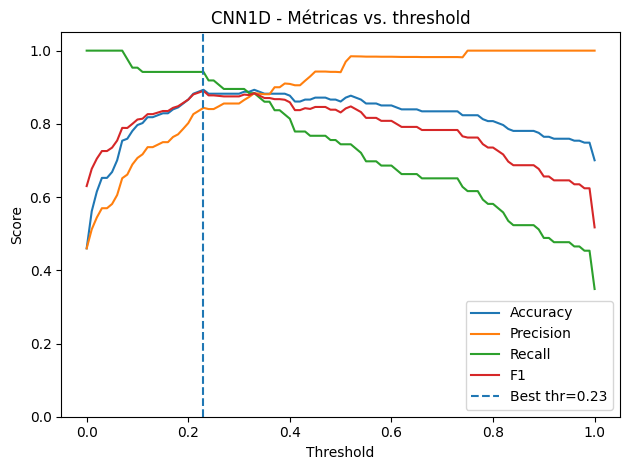

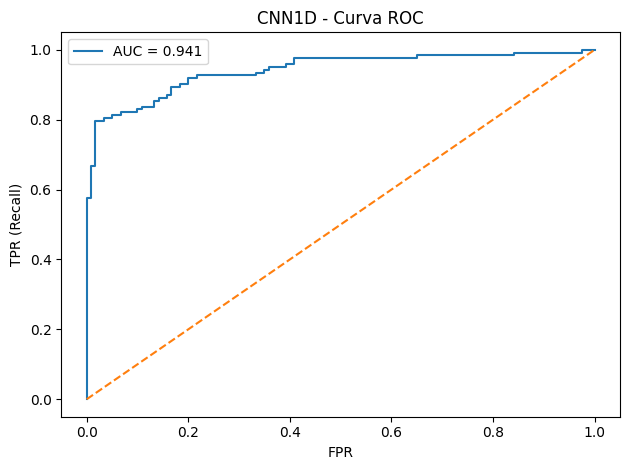

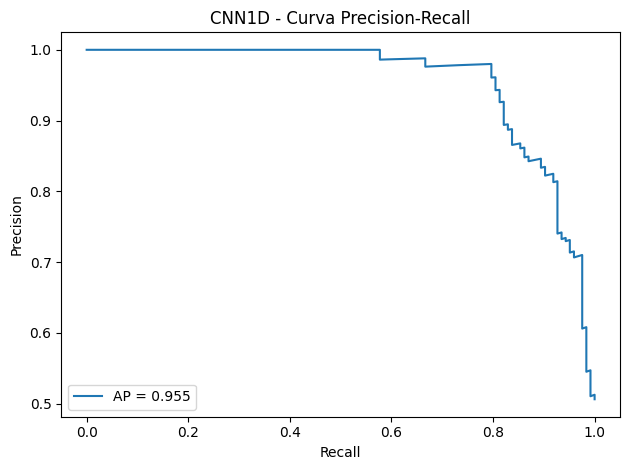

[CNN1D] @thr=0.23 Acc=0.860 P=0.825 R=0.919 F1=0.869


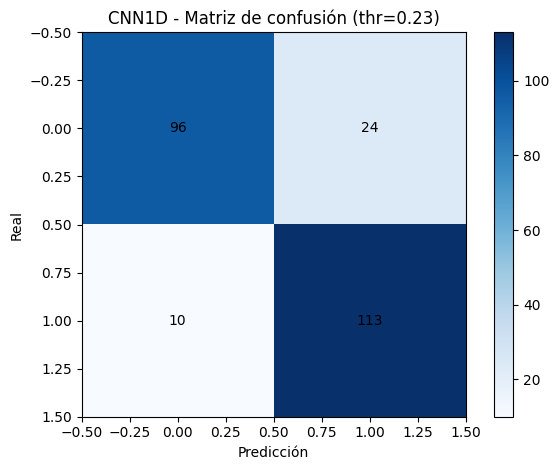

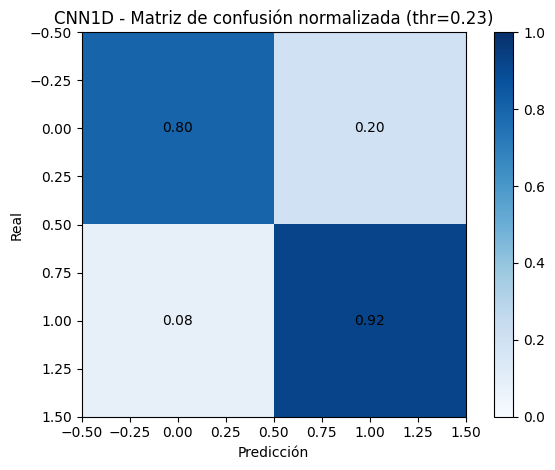

CNN2D - THR óptimo en VAL: 0.60


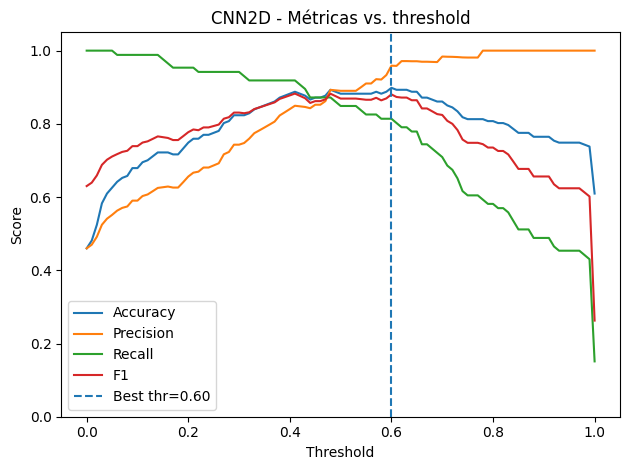

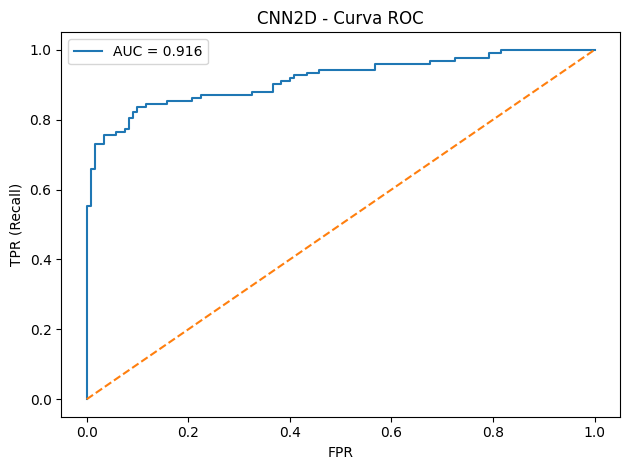

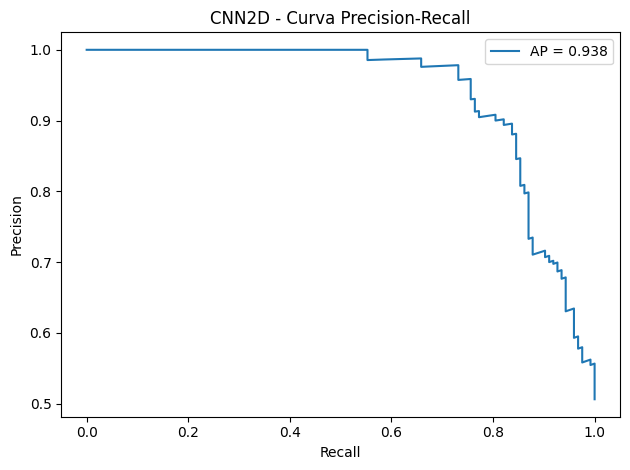

[CNN2D] @thr=0.60 Acc=0.856 P=0.978 R=0.732 F1=0.837


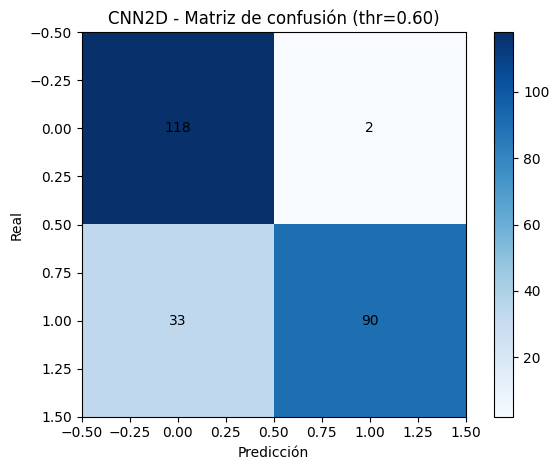

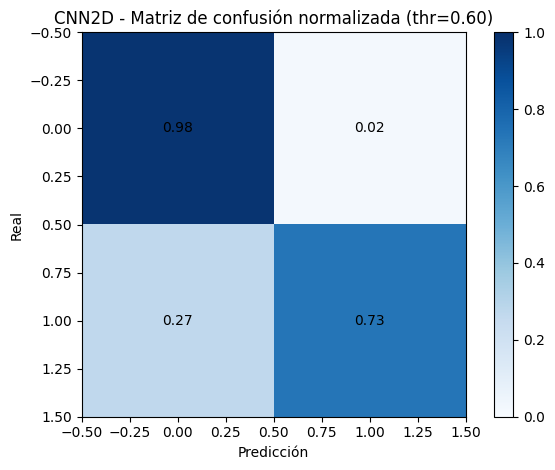

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, average_precision_score
)

def collect_probs(lightning_model, loader):
    lightning_model.eval()
    y_true, y_proba = [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = lightning_model(xb)
            probs  = torch.softmax(logits, dim=1)[:, 1]
            probs  = torch.nan_to_num(probs, nan=0.5, posinf=1.0, neginf=0.0)
            y_true.append(yb.cpu().numpy())
            y_proba.append(probs.cpu().numpy())
    y_true  = np.concatenate(y_true)
    y_proba = np.concatenate(y_proba)
    return y_true, y_proba

def choose_threshold(y_true_val, y_proba_val, criterion="f1"):
    ths = np.linspace(0.0, 1.0, 101)
    best_thr, best_val = 0.5, -1
    hist = {"thr": ths, "acc": [], "prec": [], "rec": [], "f1": []}
    for t in ths:
        y_hat = (y_proba_val >= t).astype(int)
        acc = accuracy_score(y_true_val, y_hat)
        p   = precision_score(y_true_val, y_hat, zero_division=0)
        r   = recall_score(y_true_val, y_hat, zero_division=0)
        f1  = f1_score(y_true_val, y_hat, zero_division=0)
        hist["acc"].append(acc); hist["prec"].append(p); hist["rec"].append(r); hist["f1"].append(f1)
        key = {"accuracy": acc, "f1": f1}[criterion]
        if key > best_val:
            best_val, best_thr = key, t
    for k in ("acc","prec","rec","f1"): hist[k] = np.array(hist[k])
    return best_thr, hist

def plot_threshold_history(hist, best_thr, title_prefix):
    plt.figure()
    plt.plot(hist["thr"], hist["acc"], label="Accuracy")
    plt.plot(hist["thr"], hist["prec"], label="Precision")
    plt.plot(hist["thr"], hist["rec"], label="Recall")
    plt.plot(hist["thr"], hist["f1"], label="F1")
    plt.axvline(best_thr, linestyle="--", label=f"Best thr={best_thr:.2f}")
    plt.ylim(0, 1.05)
    plt.xlabel("Threshold"); plt.ylabel("Score")
    plt.title(f"{title_prefix} - Métricas vs. threshold")
    plt.legend(); plt.tight_layout(); plt.show()

def plot_all(y_true, y_proba, model_name, threshold=None):
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_roc = roc_auc_score(y_true, y_proba)
    plt.figure(); plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("FPR"); plt.ylabel("TPR (Recall)")
    plt.title(f"{model_name} - Curva ROC"); plt.legend(); plt.tight_layout(); plt.show()

    # PR
    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.figure(); plt.plot(rec, prec, label=f"AP = {ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"{model_name} - Curva Precision-Recall"); plt.legend(); plt.tight_layout(); plt.show()

    # Si se pasa threshold, calculamos matriz y métricas en ese punto operativo
    if threshold is not None:
        y_pred = (y_proba >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        print(f"[{model_name}] @thr={threshold:.2f} Acc={accuracy_score(y_true, y_pred):.3f} "
              f"P={precision_score(y_true, y_pred, zero_division=0):.3f} "
              f"R={recall_score(y_true, y_pred, zero_division=0):.3f} "
              f"F1={f1_score(y_true, y_pred, zero_division=0):.3f}")

        plt.figure()
        plt.imshow(cm, cmap="Blues")
        plt.title(f"{model_name} - Matriz de confusión (thr={threshold:.2f})")
        plt.xlabel("Predicción"); plt.ylabel("Real")
        for i in range(2):
            for j in range(2):
                plt.text(j, i, str(cm[i, j]), ha="center", va="center")
        plt.colorbar(); plt.tight_layout(); plt.show()

        cm_norm = cm / cm.sum(axis=1, keepdims=True)
        plt.figure()
        plt.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
        plt.title(f"{model_name} - Matriz de confusión normalizada (thr={threshold:.2f})")
        plt.xlabel("Predicción"); plt.ylabel("Real")
        for i in range(2):
            for j in range(2):
                plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
        plt.colorbar(); plt.tight_layout(); plt.show()

# ========= USO PARA CNN1D =========
# Usa el best checkpoint si lo tienes, o el modelo en memoria:
# best_model_1d = LightningModel.load_from_checkpoint(best_path_1d, model=modeloCNN1D, learning_rate=1e-3, num_classes=2)
best_model_1d = cnn1D_lightning_model

# 1) Probabilidades en VALIDACIÓN: elegir threshold
y_true_val, y_proba_val = collect_probs(best_model_1d, val_loader)
thr_1d, hist_1d = choose_threshold(y_true_val, y_proba_val, criterion="accuracy")  # o "f1"
print(f"CNN1D - THR óptimo en VAL: {thr_1d:.2f}")
plot_threshold_history(hist_1d, thr_1d, "CNN1D")

# 2) Test: métricas y gráficas
y_true_test, y_proba_test = collect_probs(best_model_1d, test_loader)
plot_all(y_true_test, y_proba_test, "CNN1D", threshold=thr_1d)

# ========= USO PARA CNN2D =========
# best_model_2d = LightningModel.load_from_checkpoint(best_path_2d, model=modeloCNN2D, learning_rate=1e-3, num_classes=2)
best_model_2d = cnn_lightning_model  # si es el modelo en memoria

y_true_val2d, y_proba_val2d = collect_probs(best_model_2d, val_loader)
thr_2d, hist_2d = choose_threshold(y_true_val2d, y_proba_val2d, criterion="accuracy")
print(f"CNN2D - THR óptimo en VAL: {thr_2d:.2f}")
plot_threshold_history(hist_2d, thr_2d, "CNN2D")

y_true_test2d, y_proba_test2d = collect_probs(best_model_2d, test_loader)
plot_all(y_true_test2d, y_proba_test2d, "CNN2D", threshold=thr_2d)
